In [13]:
import os
import pandas as pd
import numpy as np
from rdkit import DataStructs
from rdkit.Chem import MolFromSmiles
from rdkit.Chem import PandasTools
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem.Descriptors import MolWt
from rdkit.Chem.inchi import MolToInchiKey

In [15]:
def process_results(file):
    # read data
    df = pd.read_csv(results_file) 
    #create eos_id
    num=[f"{i:04}" for i in range(len(df))]
    prefix="EOS-"
    batch=str(batchnum)
    eos_id=[prefix + batch +"-" + x for x in num]
    df["eosID"]=eos_id
    #add inchikey identifier
    inchikeys=[]
    smiles = [x for x in df['SMILES']]
    for smi in smiles:
        inchikey=MolToInchiKey(MolFromSmiles(smi))
        inchikeys += [inchikey]
    df["InchiKey"]=inchikeys 
    #add molecular weight
    molweights=[]
    smiles = [x for x in df['SMILES']]
    for smi in smiles:
        molweight=MolWt(MolFromSmiles(smi))
        molweights += [molweight]
    df["MW"]=molweights
    #add batch of generation 
    batch=int(results.split("results_")[-1])
    df["Batch"]=batch
    #drop undesired columns
    df=df.drop(columns=["Cluster","ID", "job_name"])
    df=df[["eosID","SMILES","InchiKey","Scaffold","MW","Batch","total_score","RestrictedSubstructure","MatchCoreSubstr"]]
    return df

def analyze_results(file):
    df=pd.read_csv(file)
    #check if structres are repeated within the file
    if df["SMILES"].duplicated().any() == True:
        print("Duplicated Smiles")
    if df["InchiKey"].duplicated().any() == True:
        print("Duplicated Inchikey")
    if df["Scaffold"].duplicated().any() == True:
        print("Duplicated Scaffold")
    else:
        print("no duplicated compounds in batch{}".format(str(batchnum)))
    
    #check if there are duplicates with original compounds
    original=pd.read_csv("../osm-series4/data/all_smiles.csv", header=None)
    old_smiles=original[0].tolist()
    new_smiles=df["SMILES"].tolist()
    duplicates=list(set(old_smiles).intersection(new_smiles))
    if not duplicates:
        print("there are no repeated smiles from original dataset")
    else:
        print(str(len(duplicates))+" SMILES will be eliminated from processed results{}".format(str(batchnum)))
        cleaned_df=df[~df["SMILES"].isin(original[0])]
    return cleaned_df  

In [16]:
DATA_PATH="C:/Users/Gemma/Desktop/progress"
for results in os.listdir(DATA_PATH):
    if "results_" in results:
        batchnum=int(results.split("results_")[-1])
        results_file=os.path.join(DATA_PATH, results, "scaffold_memory.csv")
        df=process_results(results_file)
        df.to_csv(os.path.join(DATA_PATH, "processed_results", "processed{}.csv".format(batchnum)),index=False)
for file in os.listdir(os.path.join(DATA_PATH, "processed_results")):
    if "processed" in file:
        batchnum=file.split("processed")[-1]
        batchnum=int(batchnum.strip(".csv"))
        processed_file=os.path.join(DATA_PATH, "processed_results", file)
        clean_df=analyze_results(processed_file)
        clean_df.to_csv(os.path.join(DATA_PATH, "processed_results", "cleaned{}.csv".format(batchnum)),index=False)
all_batches_dict={}
for file in os.listdir(os.path.join(DATA_PATH, "processed_results")):
    if "cleaned" in file:
        batchnum=file.split("cleaned")[-1]
        batchnum=int(batchnum.strip(".csv"))
        cleaned_file=pd.read_csv(os.path.join(DATA_PATH, "processed_results", file))
        all_batches_dict[batchnum]=cleaned_file
all_batches_df = pd.concat([df for df in all_batches_dict.values()], ignore_index=True)
all_batches_df=all_batches_df.drop_duplicates(subset="InchiKey")
all_batches_df.to_csv(os.path.join(DATA_PATH, "processed_results", "all_batches.csv"), index=False)

Duplicated Inchikey
Duplicated Scaffold
4 SMILES will be eliminated from processed results2


[0.6357481381178064, 0.6882738528769119, 0.641077441077441, 0.6141732283464567, 0.7636621717530163, 0.7315202231520224, 0.6324216144096064, 0.7178571428571429, 0.7197724039829303, 0.7765151515151515, 0.693304535637149, 0.62875, 0.7097004279600571, 0.7586206896551724, 0.7614942528735632, 0.7453769559032717, 0.6765129682997119, 0.9134840218238504, 0.8920585967617579, 0.7223756906077348, 0.6553867403314917, 0.7574257425742574, 0.771326164874552, 0.7724679029957204, 0.6858156028368795, 0.7244318181818182, 0.7858703568827385, 0.6924657534246575, 0.802930402930403, 0.789587852494577, 0.8278688524590164, 0.6514131897711979, 0.8297557364914878, 0.7921795800144823, 0.9443118536197295, 0.6278755074424899, 0.8020911127707244, 0.6347886347886348, 0.7830330330330331, 0.7426470588235294, 0.6607270135424091, 0.6442769019876627, 0.6452054794520548, 0.7282913165266106, 0.6936026936026936, 0.7226705796038151, 0.6417508417508417, 0.6361731843575419, 0.8149518874907475, 0.7247706422018348, 0.7010309278350

(array([1.510e+02, 3.950e+02, 1.890e+03, 4.069e+03, 2.649e+03, 6.750e+02,
        1.370e+02, 2.000e+01, 1.000e+01, 4.000e+00]),
 array([0.47994467, 0.52905046, 0.57815624, 0.62726202, 0.6763678 ,
        0.72547358, 0.77457936, 0.82368514, 0.87279092, 0.9218967 ,
        0.97100249]),
 <BarContainer object of 10 artists>)

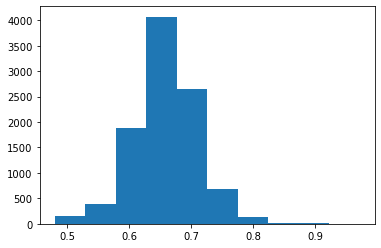

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

df=pd.read_csv(os.path.join(DATA_PATH,"processed_results", "all_batches.csv"))
df=df.head(1000)#there are too many smiles

smiles_list = [x for x in df['SMILES']] #obtain list of smiles
mols_list=[MolFromSmiles(x) for x in smiles_list] #create list of mols
fps_list=[FingerprintMols.FingerprintMol(x) for x in mols_list] #create list of fingerprints

query, target, sim = [] , [], [] #create empty lists for query molecule, comparison molecule and similarity value

for fp in range(len(fps_list)-1):
    similarity= DataStructs.BulkTanimotoSimilarity(fps_list[fp], fps_list[fp+1:])
    for s in range(len(similarity)):
        query.append(smiles_list[fp])
        target.append(smiles_list[fp+1:][s])
        sim.append(similarity[s])
d = {'query':query, 'target':target, 'similarity':sim}
df_sim = pd.DataFrame(data=d)
        
print(sim[:100])
plt.hist(sim[:10000])

In [28]:
### Check predictions using AutoML

#create smiles file
df=pd.read_csv(os.path.join(DATA_PATH,"processed_results", "all_batches.csv")) 
df.rename(columns={"SMILES":"smiles",
                   },
                   inplace=True)
df=df["smiles"]

df.to_csv(os.path.join(DATA_PATH,"auto-ml-chemistry", "data_clf_test.csv"), index=False) #run dev_clf.py from Miquel's computer

,smiles,ROMol
0,FC(F)Oc1ccc(-c2nnc3cncc(OCCc4ccc(Cl)c(Cl)c4)n2...,
1,N#Cc1ccc(-c2ccc(CCOc3cncc4nnc(-c5ccc(Cl)cc5)n3...,
2,Fc1cc(-c2nnc3cncc(OCCc4ccc(Br)cc4)n23)ccc1Cl,
3,Fc1cc(CCOc2cncc3nnc(-c4ccc(Br)cc4)n23)ccc1Cl,
4,Fc1ccc(CCOc2cncc3nnc(-c4ccc(Br)cc4)n23)cc1Cl,
...,...,...
105,FC(F)Oc1ccc(-c2nnc3cncc(OCc4ccc(Cl)cc4)n23)cc1,
106,Fc1ccc(CCCOc2cncc3nnc(-c4ccc(Cl)cc4)n23)cc1F,
107,Fc1cccc(CCOc2cncc3nnc(-c4ccc(OC(F)F)cc4)n23)c1,
108,Fc1ccccc1CCOc1cncc2nnc(-c3ccc(OC(F)F)cc3)n12,

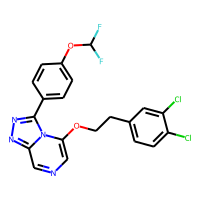
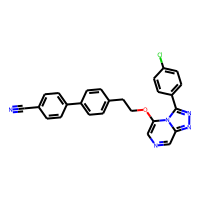
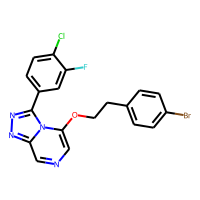
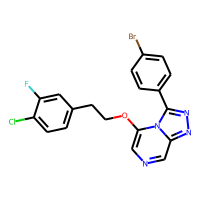
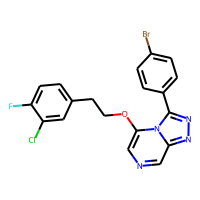
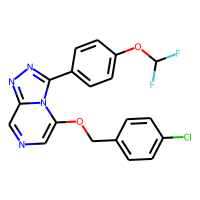
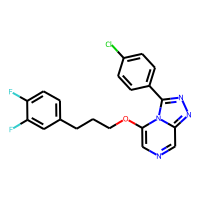
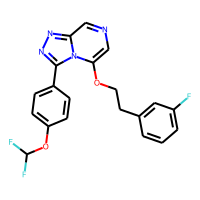
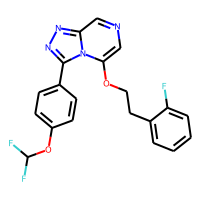
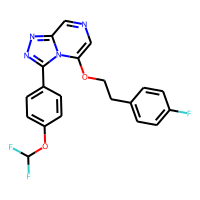

In [34]:
df=pd.read_csv("C:/Users/Gemma/Downloads/some_smiles_gemma.csv")

PandasTools.AddMoleculeColumnToFrame(df, "smiles")
df
